In [160]:
#import all libraries needed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [161]:
#Load and display first 5 rows of the data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('insurance.csv')
print(df.head())

Saving insurance.csv to insurance (5).csv
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [162]:
#to see how big the data is we print no. of rows and columns
print(df.shape)

#see column names, data types
print(df.info())

#Check if any values are missing in any column
print(df.isnull().sum())

#See if there are any duplicate rows
print("duplicated rows:",df.duplicated().sum())

#Show summary stats for number columns To check for weird values like negative charges or extremely high ages
print(df.describe())

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
duplicated rows: 1
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.00

we found no missing values and one duplicate row

In [163]:
#Remove duplicates
df = df.drop_duplicates()
# Check new shape to confirm removal
print("New shape after removing duplicates:", df.shape)


New shape after removing duplicates: (1337, 7)


In [164]:
#check all the unique values in the 3 text columns (because there might be Male and male and computer might take them for 2 different values.)
print("Unique values in 'sex':", df['sex'].unique())
print("Unique values in 'smoker':", df['smoker'].unique())
print("Unique values in 'region':", df['region'].unique())

Unique values in 'sex': ['female' 'male']
Unique values in 'smoker': ['yes' 'no']
Unique values in 'region': ['southwest' 'southeast' 'northwest' 'northeast']


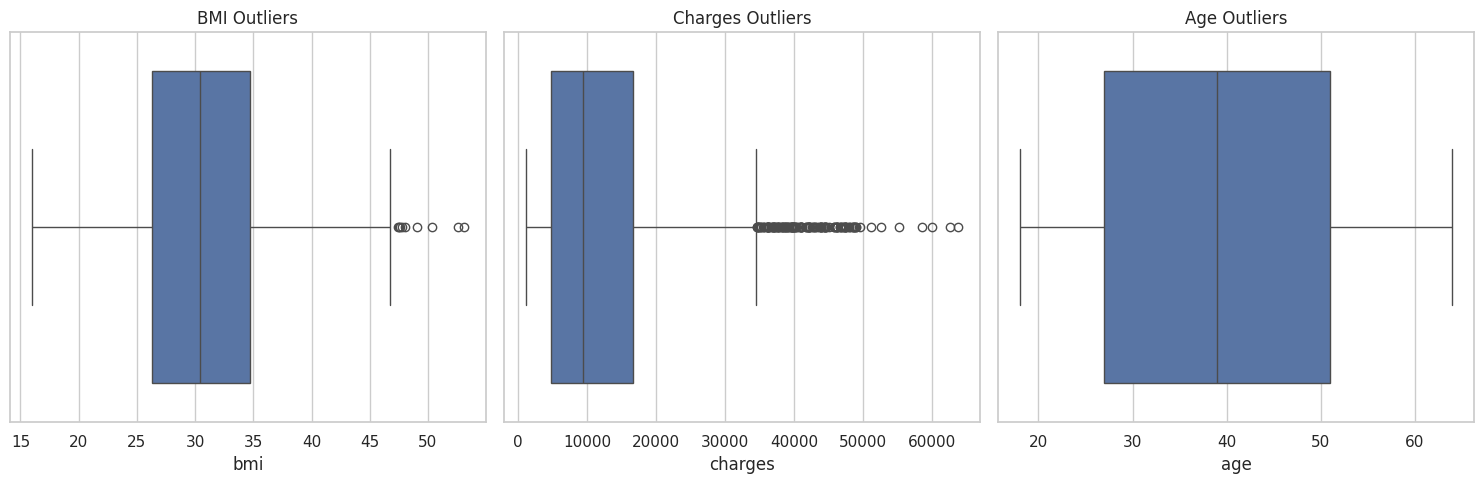

In [165]:
#Plot boxplots for numerical columns
plt.figure(figsize=(15, 5))

#Boxplot for 'bmi'
plt.subplot(1, 3, 1)
sns.boxplot(x=df['bmi'])
plt.title('BMI Outliers')

#Boxplot for 'charges'
plt.subplot(1, 3, 2)
sns.boxplot(x=df['charges'])
plt.title('Charges Outliers')

#Boxplot for 'age'
plt.subplot(1, 3, 3)
sns.boxplot(x=df['age'])
plt.title('Age Outliers')

plt.tight_layout()#automatically adjusts the spacing between plots
plt.show()


THE CHILDREN COLUMN DOESNT NEED BOXPLOT:
The children column has only whole numbers in a small range (0–5), and all values are realistic.
Since it's not continuous like bmi or charges, boxplots aren't useful here.
There are also no outliers like negative numbers or values like 20.
So, no outlier handling is needed asthe data is already clean.

BMI:Has some right-side outliers (higher BMI values beyond the whisker).

Charges: Has significant right-side outliers (very high charges).

Age:No outliers (all values lie neatly between the whiskers).

In [166]:
#make a copy of the original data
cleaned_df = df.copy()

# Define a function to remove outliers using IQR (Interquartile Range method)
def remove_outliers_iqr(df, col):
    #Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Step 2: Calculate the IQR
    IQR = Q3 - Q1

    #Find the lower and upper limits to detect outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Filter out the outliers (keep only values inside the bounds)
    filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    #Show how many rows were removed
    removed = df.shape[0] - filtered_df.shape[0]
    print(f"\nOutlier removal for '{col}':")
    print(f"  Lower Bound = {lower_bound}")
    print(f"  Upper Bound = {upper_bound}")
    print(f"  {removed} outliers removed from '{col}'")

    #Return the cleaned data
    return filtered_df

#Now we apply the function to the 'bmi' and 'charges' columns
for col in ['bmi', 'charges']:
    cleaned_df = remove_outliers_iqr(cleaned_df, col)

#check the final number of rows after outlier removal
print("Final data shape after outlier removal:", cleaned_df.shape)




Outlier removal for 'bmi':
  Lower Bound = 13.674999999999994
  Upper Bound = 47.31500000000001
  9 outliers removed from 'bmi'

Outlier removal for 'charges':
  Lower Bound = -13045.6413425
  Upper Bound = 34394.269037499995
  138 outliers removed from 'charges'
Final data shape after outlier removal: (1190, 7)


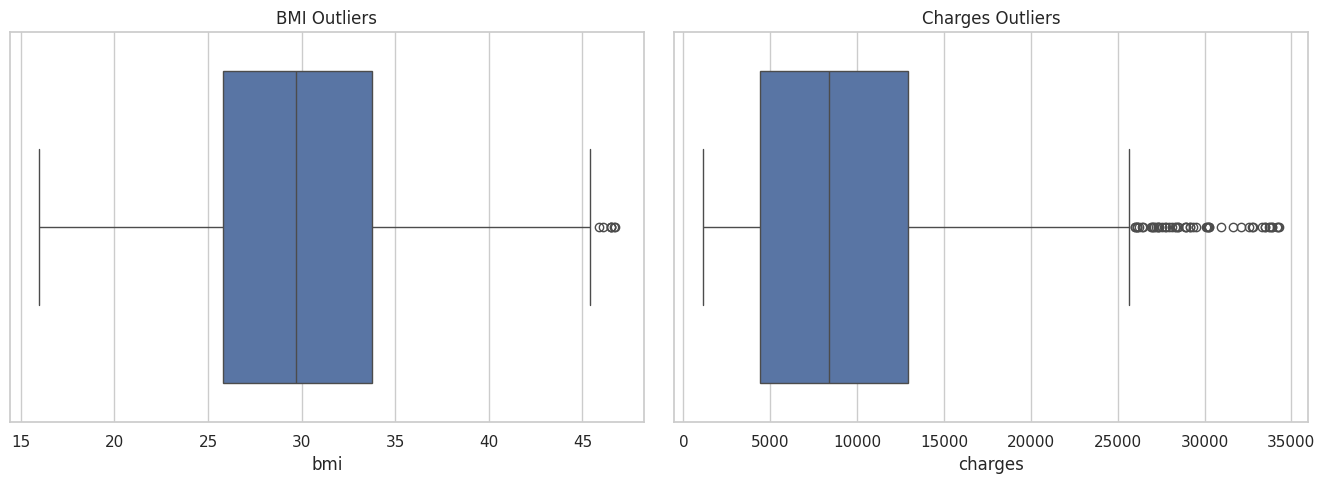

In [167]:
#Plot boxplots for numerical columns
plt.figure(figsize=(20, 5))

#Boxplot for 'bmi'
plt.subplot(1, 3, 1)
sns.boxplot(x=cleaned_df['bmi'])
plt.title('BMI Outliers')

#Boxplot for 'charges'
plt.subplot(1, 3, 2)
sns.boxplot(x=cleaned_df['charges'])
plt.title('Charges Outliers')

plt.tight_layout()#automatically adjusts the spacing between plots
plt.show()

In [168]:
# 👉 Manually remove very high charges (beyond 30,000)
cleaned_df = cleaned_df[cleaned_df['bmi'] < 45]

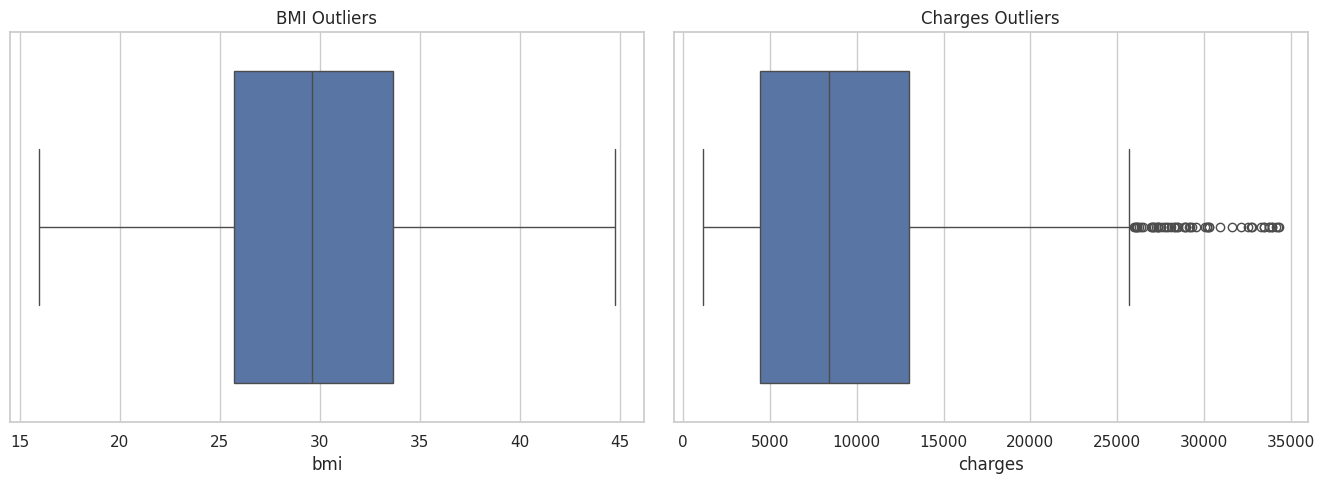

In [169]:
#Plot boxplots for numerical columns
plt.figure(figsize=(20, 5))

#Boxplot for 'bmi'
plt.subplot(1, 3, 1)
sns.boxplot(x=cleaned_df['bmi'])
plt.title('BMI Outliers')

#Boxplot for 'charges'
plt.subplot(1, 3, 2)
sns.boxplot(x=cleaned_df['charges'])
plt.title('Charges Outliers')

plt.tight_layout()
plt.show()

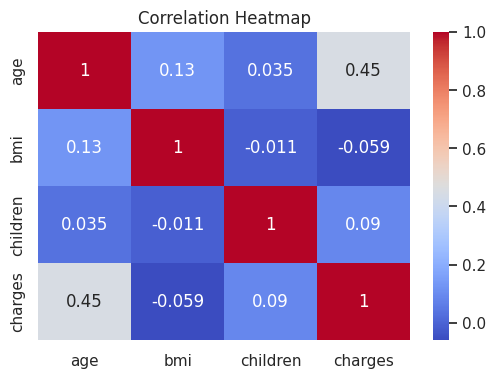

In [170]:
# Calculate correlation
corr = cleaned_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [171]:
#list the categorical columns
categorical_cols = ['sex', 'smoker', 'region']

# Initialize LabelEncoder for each categorical column
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_region = LabelEncoder()

# Fit and transform the categorical columns
df['sex'] = le_sex.fit_transform(df['sex'])
df['smoker'] = le_smoker.fit_transform(df['smoker'])
df['region'] = le_region.fit_transform(df['region'])

# Verify the encoded values (optional)
print("Encoded 'sex' values:", df['sex'].unique())
print("Encoded 'smoker' values:", df['smoker'].unique())
print("Encoded 'region' values:", df['region'].unique())


Encoded 'sex' values: [0 1]
Encoded 'smoker' values: [1 0]
Encoded 'region' values: [3 2 1 0]


What drop_first=True means:
It drops one column from each category group to avoid dummy variable trap (where multicollinearity occurs).

For example, if sex has ['male', 'female'], only one column like sex_male is kept (female becomes the default).

In [172]:
print("Columns after encoding:")
print(df.columns.tolist())

Columns after encoding:
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [173]:
# Define the numerical columns to scale
num_cols = ['age', 'bmi', 'children']

# Create the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[num_cols] = scaler.fit_transform(df[num_cols])

# Show the scaled data
print("Scaled data (first 5 rows):")
print(df[num_cols].head())

# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaled data (first 5 rows):
        age       bmi  children
0 -1.440418 -0.453160 -0.909234
1 -1.511647  0.509422 -0.079442
2 -0.799350  0.383155  1.580143
3 -0.443201 -1.305052 -0.909234
4 -0.514431 -0.292456 -0.909234


###Feature Scaling
We scale `age`, `bmi`, and `children` using StandardScaler to ensure all features are on a similar range, which helps regression models perform better.


we don't scale charges because:
`charges` is the target/output we’re trying to predict.In this dataset, the `charges` column represents the medical insurance cost for each person.

It should be left unscaled so that we can evaluate models using actual money values

In [174]:
# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Compute mutual information scores
mi_scores = mutual_info_regression(X, y)

# Store scores in a DataFrame
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})

# Sort by importance
mi_df.sort_values(by='MI Score', ascending=False, inplace=True)

# Display the feature importance table
print(mi_df)

    Feature  MI Score
0       age  1.496209
4    smoker  0.369276
1       sex  0.176281
3  children  0.161120
5    region  0.075482
2       bmi  0.073748


In [175]:
# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Feature selection using Random Forest importance
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# Create a DataFrame
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

# Select top 6 features
top_features = feat_imp.head(6)['Feature'].tolist()
print("Top features selected by Random Forest:", top_features)

# Subset the features
X_selected = X[top_features]


Top features selected by Random Forest: ['smoker', 'bmi', 'age', 'children', 'region', 'sex']


In [176]:
# Train the models
# Split into training (80%) and testing (20%)
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

print("Training set size:", X_train_sel.shape)
print("Test set size:", X_test_sel.shape)


Training set size: (1069, 6)
Test set size: (268, 6)


What is `random_state`?

`random_state` sets the seed for random number generation while splitting the data.  
It ensures that the train-test split is always the same, making the results reproducible every time the code is run.


In [177]:
# Initialize models
lin_reg = LinearRegression()
ridge_reg = Ridge(alpha=1.0)
lasso_reg = Lasso(alpha=0.01)

# Fit models
lin_reg.fit(X_train_sel, y_train)
ridge_reg.fit(X_train_sel, y_train)
lasso_reg.fit(X_train_sel, y_train)

# Predict on test data
models = {
    "Linear Regression": lin_reg,
    "Ridge Regression": ridge_reg,
    "Lasso Regression": lasso_reg
}

#Evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test_sel)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.4f}")

Linear Regression
Mean Squared Error: 35493102.61
R² Score: 0.8068
Ridge Regression
Mean Squared Error: 35673339.97
R² Score: 0.8059
Lasso Regression
Mean Squared Error: 35493213.35
R² Score: 0.8068


we are working on a regression problem, because our target (charges) is a continuous numerical value (like 12,000, 34,000, etc).so,
Use Linear, Ridge, Lasso For predicting numbers.
Do not use Logistic Regression. It’s for classification problems (yes/no, male/female, 0/1)

ROC-AUC is only for classification problems. Its not needed for predicting charges.ROC-AUC measures how well a model distinguishes between classes (like spam vs not spam).

In [178]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_sel, y_train)
y_pred = rf_model.predict(X_test_sel)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

Random Forest Regressor
Mean Squared Error: 21525806.98
R² Score: 0.8829


here we can see, the random forest model gives the best and highest R² value (0.889) for this particular data usage of Label Encoder worked best as it improved R² better than one hot encoder.